In [1]:
import random
import os
import sys
import warnings
import datetime

# Helper libraries
import numpy as np
import numpy.matlib
from numpy.fft import fft, ifft

import matplotlib.pyplot as plt

import scipy
from scipy.signal import butter, filtfilt
from scipy.stats import norm
import scipy.io

import segyio

from skimage.metrics import structural_similarity as ssim
# from skimage.measure import compare_ssim 
from skimage.metrics import peak_signal_noise_ratio as psnr

#TensorFlow libraries
#TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks, models, losses

from tqdm import tqdm
print(f'TensorFlow Version:',tf.__version__)
print(tf.config.list_physical_devices())



TensorFlow Version: 2.9.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [2]:
## Training and test gathers  
NN_training =24 # number Training Gathers
NN_test =  2  # Number Test Gathers
TPG = 640# Traces per gather 
    # Data set
ini_trace = 0
end_trace = TPG*(NN_training+NN_test) # Trace Per Gather
ini_time = 0 # Initial time (sec) for the gather
end_time = 254*6 # End time (sec) for the gather
    # Sliding Window for the tx and fk domain
window_height = 254
window_height_fk = int(np.floor(window_height/2)+1)
window_width = 64
NN_windows = int(np.floor(((TPG)/window_width)*np.floor((end_time-ini_time)/window_height))) # Number of training windows     

## saving Training and Test
X_tr=np.zeros((NN_training*NN_windows,window_width,window_height,1))
Filt_tr=np.zeros((NN_training*NN_windows,window_width,window_height,1))
FK_tr = np.zeros((NN_training*NN_windows,window_width,window_height_fk,1))
FK_filt_tr = np.zeros((NN_training*NN_windows,window_width,window_height_fk,1))
Inv_FK_tr = np.zeros((NN_training*NN_windows,window_width,window_height,1))
Inv_FK_Filt_tr = np.zeros((NN_training*NN_windows,window_width,window_height,1))
    # Saving Test Data set
X_te=np.zeros((NN_test*NN_windows,window_width,window_height,1))
Filt_te=np.zeros((NN_test*NN_windows,window_width,window_height,1))
FK_te = np.zeros((NN_test*NN_windows,window_width,window_height_fk,1))
FK_filt_te = np.zeros((NN_test*NN_windows,window_width,window_height_fk,1))
Inv_FK_te = np.zeros((NN_test*NN_windows,window_width,window_height,1))
Inv_FK_Filt_te = np.zeros((NN_test*NN_windows,window_width,window_height,1))
    # Saving Frequency
Freq_Train = np.zeros((NN_training,1))
Freq_Test = np.zeros((NN_test,1))

print(f'Num of windows = {NN_windows}')
print(Filt_te.shape)



Num of windows = 60
(120, 64, 254, 1)


In [3]:
## Filter function
def myStrongFilter(data,flp,fhi,delt):
    #data - input time series
    #flp - lowpass corner freq of filter
    #fhi - highpass corner freq
    #delt - sampling interval of the data
    
    flp = flp
    fhi = fhi
    
    Fs = 1/delt
    Nyq = Nyq = Fs/2
    
    Data_Freq = np.fft.fft(data)
    Filter = np.ones(Data_Freq.shape)
    Filter[:,int(np.ceil((flp/Nyq)*Data_Freq.shape[0])):int(np.ceil((fhi/Nyq)*Data_Freq.shape[0]))] = 0
    Filter[:,-int(np.ceil((fhi/Nyq)*Data_Freq.shape[0])):-int(np.ceil((flp/Nyq)*Data_Freq.shape[0]))] = 0

    Data_Freq_Filt = Data_Freq*Filter
    
    return np.real(ifft(Data_Freq_Filt))

In [4]:


## Sliding window to store training and test data - One gather at a time (1600*636) with no over lap 
# Here, a windoe size of one gather is moved over 10 gather and storing the rfft and irfft gather
path = 'C:/Users/Ssach/OneDrive - Delft University of Technology/AGP/Thesis/Sam - Github/Neural Network/' 
filename = 'IRP1909132tlaa.P_s1_c5_LC.sgy'
counter=0
dt = 0.004
#list_window=[]
#list_gather=[]
#list_rfft_train=[]
#list_irfft_train=[]
flp=20
fhi=30
counter = 0
with segyio.open(path + filename, ignore_geometry=True) as f:
    
    ## Training Set
   
    for k in tqdm (np.arange(NN_training)):
        gather = f.trace.raw[:][k+k*(TPG):k+(k+1)*(TPG),ini_time:end_time] #.reshape((len(f.samples),f.tracecount))[ini_time:end_time,k+k*(TPG) : k+(k+1)*(TPG)]
        #print(gather.shape)
        
        #gather = segyio.tools.collect(f.trace[k+k*(TPG) : k+(k+1)*(TPG),ini_time:end_time])
        for i in range (0,gather.shape[0],window_width):
            g_s = i
            g_e = i+window_width
            #list_gather.append(list_window)
            for j in range (0,gather.shape[1],window_height):
                t_s=j
                t_e = j+window_height
                window = gather[g_s:g_e,t_s:t_e]
                
                #if np.any(window) == True:
                    
                #(f._samples,f._xlines) = butter(5,[flp/250,fhi/250],'stop')
                #filtered_train = filtfilt(f._samples,f._xlines,window)
                filtered_train = myStrongFilter(window,20,25,dt)

                fk_train = (np.fft.rfft2(window))
                #inv_fk_train = (np.fft.irfft2(fk_train))
                
                fk_filt_train = (np.fft.rfft2(filtered_train))
                #inv_fk_filt_train = (np.fft.irfft2(fk_filt_train))
            
                ## Sanvig window into a list 
                #list_window.append(filtered_train)
                #list_rfft_train.append(fk_filt_train)
                #list_irfft_train.append(inv_fk_train)
                
        
                ## Saving windows into an array 
                #X_tr[counter] = window.reshape((window_width,window_height,1))
                #Filt_tr[counter] = filtered_train.reshape((window_width,window_height,1))
                FK_tr[counter] = fk_train.reshape((window_width,window_height_fk,1))
                #Inv_FK_tr[counter] = inv_fk_train.reshape((window_width,window_height,1))
                FK_filt_tr[counter] = fk_filt_train.reshape((window_width,window_height_fk,1))
                #Inv_FK_Filt_tr[counter] = inv_fk_filt_train.reshape((window_width,window_height,1))

                counter +=1 
                  
        
##  Creating Test Samples      
     
    #with segyio.open(path + filename, ignore_geometry=True) as f:       
    #list_raw_test =[]
    #list_rfft_test=[]
   #list_irfft_test=[]
    counter =0 
    ## Test Set 
    for k in tqdm (np.arange(NN_training,NN_training+NN_test)):
        gather = f.trace.raw[:][k+k*(TPG):k+(k+1)*(TPG),ini_time:end_time]
        #gather = segyio.tools.collect(f.trace[k+k*(TPG): k+(k+1)*(TPG),ini_time:end_time])
        
        
        for i in range (0,gather.shape[0],window_width):
            g_s = i
            g_e = i+window_width
            for j in range (0,gather.shape[1],window_height):
                t_s=j
                t_e = j+window_height
                window= gather[g_s:g_e,t_s:t_e]
                #if np.any(window) == True:
                    
                #(f._samples,f._xlines) = butter(5,[flp/250,fhi/250],'stop')
                #filtered_test = filtfilt(f._samples,f._xlines,window)
                filtered_test =   myStrongFilter(window,flp,fhi,dt)
                fk_test =(np.fft.rfft2(window))
                #inv_fk_test = (np.fft.irfft2(fk_test))
                
                fk_filt_test = (np.fft.rfft2(filtered_test))
                #inv_fk_filt_test = (np.fft.irfft2(fk_filt_test))
                
                ## Sanvig window into a list 
                #list_raw_train.append(filtered_train)
                #list_rfft_train.append(rfft_train)
                #list_irfft_train.append(irfft_train)
                
                ## Saving windows into an array 
                #X_te[counter] = window.reshape(window_width,window_height,1)
                #Filt_te[counter] = filtered_test.reshape(window_width,window_height,1)
                FK_te[counter] = fk_test.reshape((window_width,window_height_fk,1))
                #Inv_FK_te[counter] = inv_fk_test.reshape((window_width,window_height,1))
                FK_filt_te[counter] = fk_filt_test.reshape((window_width,window_height_fk,1))
                #Inv_FK_Filt_te[counter] = inv_fk_filt_test.reshape(window_width,window_height,1)
                
                counter +=1 
    f.close()  

_, b = np.unique(FK_tr, return_index = 1 ,axis=0)
FK_filt_tr = FK_filt_tr[np.sort(b)] 
FK_tr = FK_tr[np.sort(b)]  
del gather
del _
del b




print('Done!')
print(f'There are {Filt_tr.shape[0]} training samples of size {Filt_tr[1].shape}.')
print(f'There are {FK_te.shape[0]} test samples of size {FK_te[0].shape}.')
#print(f'There are {len(list_window)} 2d window of size {list_window[1].shape}.')
#print(f'There are {len(list_rfft_train)} 2d window of size {list_rfft_train[1].shape} in FK domain.')




  0%|          | 0/24 [00:00<?, ?it/s]C:\Users\Ssach\AppData\Local\Temp\ipykernel_25624\1466566765.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  FK_tr[counter] = fk_train.reshape((window_width,window_height_fk,1))
C:\Users\Ssach\AppData\Local\Temp\ipykernel_25624\1466566765.py:55: ComplexWarning: Casting complex values to real discards the imaginary part
  FK_filt_tr[counter] = fk_filt_train.reshape((window_width,window_height_fk,1))
  0%|          | 0/2 [00:00<?, ?it/s]C:\Users\Ssach\AppData\Local\Temp\ipykernel_25624\1466566765.py:100: ComplexWarning: Casting complex values to real discards the imaginary part
  FK_te[counter] = fk_test.reshape((window_width,window_height_fk,1))
C:\Users\Ssach\AppData\Local\Temp\ipykernel_25624\1466566765.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  FK_filt_te[counter] = fk_filt_test.reshape((window_width,window_height_fk,1))
100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


Done!
There are 1440 training samples of size (64, 254, 1).
There are 120 test samples of size (64, 128, 1).


In [5]:
## Normalization: 
# 1. Normalize the Training and Test Set by the maximum in the whole data set
normfac = np.max(np.array([
                              np.max(np.abs(FK_filt_tr)), 
                              np.max(np.abs(FK_tr)),
                              np.max(np.abs(FK_filt_te)), 
                              np.max(np.abs(FK_te))]))
print(normfac)

FK_filt_tr = ((FK_filt_tr / normfac) + 1) / 2
FK_tr = ((FK_tr / normfac) + 1) / 2
FK_filt_te = ((FK_filt_te / normfac) + 1) / 2
FK_te = ((FK_te / normfac) + 1) / 2




3758586.622197992


In [7]:
FK_filt_te.shape


(120, 64, 128, 1)

(64, 254)


"plt.subplot(152)\nplt.imshow(irfft.T,cmap='seismic',vmax=100,vmin=-100)\nplt.colorbar()\nplt.xlabel('Offset')\nplt.ylabel('Time')\nplt.title('IRFFT')\nplt.subplot(153)\nplt.imshow (np.abs(rfft).T,cmap='seismic', extent =[0,250,200,0])\nplt.xlabel('Wavenumber')\nplt.ylabel('Frequency')\nplt.title('FK')\nplt.subplot(154)\nplt.imshow (np.abs(rfft_filtered).T,cmap='seismic', extent =[0,250,200,0])\nplt.xlabel('Wavenumber')\nplt.ylabel('Frequency')\nplt.title('Filtered FK')\nplt.subplot(155)\nplt.imshow((data-irfft).T,cmap='seismic')\nplt.colorbar()\nplt.title('Difference Data - IRFFT')"

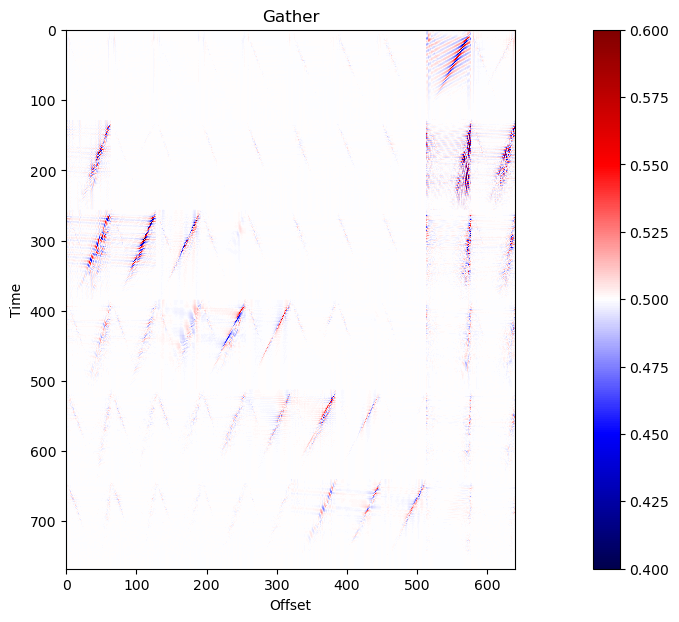

In [8]:
#print(gather.shape)
print(filtered_train.shape)
data = np.zeros((TPG,128*6))
rfft = np.zeros((TPG,128*6))
rfft_filtered= np.zeros((640,128*6))
rfft_filtered_1= np.zeros((640,128*6))
irfft = np.zeros((TPG,254*6))
irfft_filtered= np.zeros((640,254*6))
counter =0 
q=[]

for i in range (0,TPG,window_width):
    for j in range (0,128*6,window_height_fk):
        a = FK_te[counter,:,:]
       
        b= Inv_FK_te[counter,:,:]
        c=  FK_te[counter,:,:]
        d=  FK_filt_te[counter,:,:] 
        #d_1=  FK_filt_tr_1[counter,:,:] 
        e = Inv_FK_Filt_te[counter,:,:]    
        
        data[i:i+window_width,j:j+window_height_fk] = a.reshape((window_width,window_height_fk))
        #irfft[i*64:64*i+64,j*254:254*j+254] = b.reshape((64,254))
        #rfft[i*64:64*i+64,j*128:128*j+128] = c.reshape((64,128))
        #rfft_filtered[i*64:64*i+64,j*128:128*j+128] = d.reshape((64,128))
        #rfft_filtered_1[i*64:64*i+64,j*128:128*j+128] = d_1.reshape((64,128))
        #irfft_filtered[i*64:64*i+64,j*254:254*j+254] = e.reshape((64,254))  
        
        
        counter +=1
plt.figure(figsize=(20,7))
#plt.subplot(151)
plt.imshow(np.abs(data.T),cmap='seismic')
plt.colorbar()
plt.clim(0.4,0.6)
plt.xlabel('Offset')
plt.ylabel('Time')
plt.title('Gather')
'''plt.subplot(152)
plt.imshow(irfft.T,cmap='seismic',vmax=100,vmin=-100)
plt.colorbar()
plt.xlabel('Offset')
plt.ylabel('Time')
plt.title('IRFFT')
plt.subplot(153)
plt.imshow (np.abs(rfft).T,cmap='seismic', extent =[0,250,200,0])
plt.xlabel('Wavenumber')
plt.ylabel('Frequency')
plt.title('FK')
plt.subplot(154)
plt.imshow (np.abs(rfft_filtered).T,cmap='seismic', extent =[0,250,200,0])
plt.xlabel('Wavenumber')
plt.ylabel('Frequency')
plt.title('Filtered FK')
plt.subplot(155)
plt.imshow((data-irfft).T,cmap='seismic')
plt.colorbar()
plt.title('Difference Data - IRFFT')'''

In [9]:
'''## Checking Function
def myStrongFilter(data,flp,fhi,delt):
    #data - input time series
    #flp - lowpass corner freq of filter
    #fhi - highpass corner freq
    #delt - sampling interval of the data
    
    flp = flp
    fhi = fhi
    
    Fs = 1/delt
    Nyq = Nyq = Fs
    
    Data_Freq = np.fft.fft(data)
    Filter = np.ones(Data_Freq.shape)
    Filter[:,int(np.ceil((flp/Nyq)*Data_Freq.shape[0])):int(np.ceil((fhi/Nyq)*Data_Freq.shape[0]))] = 0
    Filter[:,-int(np.ceil((fhi/Nyq)*Data_Freq.shape[0])):-int(np.ceil((flp/Nyq)*Data_Freq.shape[0]))] = 0

    Data_Freq_Filt = Data_Freq*Filter
    
    return np.real(ifft(Data_Freq_Filt))
data = np.fft.fft(gather)'''


'''qwe =   myStrongFilter(gather,40,100,dt)
plt.subplot(121)
plt.imshow(np.abs(np.fft.rfft2(gather)),cmap='seismic',extent=[0,125,64,128])
plt.subplot(122)
plt.imshow(np.abs(np.fft.rfft2(qwe)),cmap='seismic',extent=[0,125,64,128])'''

"qwe =   myStrongFilter(gather,40,100,dt)\nplt.subplot(121)\nplt.imshow(np.abs(np.fft.rfft2(gather)),cmap='seismic',extent=[0,125,64,128])\nplt.subplot(122)\nplt.imshow(np.abs(np.fft.rfft2(qwe)),cmap='seismic',extent=[0,125,64,128])"

In [10]:
from tensorflow_estimator.python.estimator.api._v2 import estimator as estimator
from keras.api._v2 import keras
from keras.api._v2.keras import losses
from keras.api._v2.keras import models
from keras.api._v2.keras import layers
from keras.api._v2.keras import callbacks
from keras.layers import concatenate, Concatenate

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Conv2D, Conv2DTranspose, ReLU, Activation, MaxPooling2D
from keras.models import Model, load_model
from keras.models import Sequential 

#Frequency loss function that takes the frequency data into account. 
def FreqLoss(y_true, y_pred):
    
    #Create Huber loss function
    h = tf.keras.losses.Huber()
    L1 = h(y_true, y_pred)
    
    #Cast in- and output data in complex for to perform fft
    '''y_true_f = tf.dtypes.cast(y_true, tf.complex64)
    y_pred_f = tf.dtypes.cast(y_pred, tf.complex64)
    
    #Compute fft
    y_true_fft = tf.signal.fft3d(y_true_f)
    y_pred_fft = tf.signal.fft3d(y_pred_f)
    
    #Compute MAE of frequency domain data
    FreqRMS = tf.math.reduce_mean(tf.abs(y_true_fft-y_pred_fft))'''
    
    return  L1

#Convolution block
def conv_block(inp, num_filters):
    x = Conv2D(num_filters, (3,3), padding="same", activation="relu",kernel_initializer='HeNormal')(inp)
    x = Conv2D(num_filters, (3,3), padding="same", activation="relu",kernel_initializer='HeNormal')(x)
#     coordinate_attention = CoordAtt(x)
#     x = Add()([coordinate_attention, x])
    return x

#Encoding block
def encoder_block(inp, num_filters):
    x = conv_block(inp, num_filters) #also the skip feature
    p = MaxPooling2D((2, 2))(x) #output to the next block
    return x, p

#Decoding block
def decoder_block(inp, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (3, 3), strides=(2,2), padding="same",kernel_initializer='HeNormal')(inp)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x




In [11]:
def build_unet(input_shape, start_neurons):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, start_neurons * 1) 
    s2, p2 = encoder_block(p1, start_neurons * 2)

    b1 = conv_block(p2, start_neurons * 16)

    d2 = decoder_block(b1, s2, start_neurons * 2)
    d1 = decoder_block(d2, s1, start_neurons * 1)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d1)

    model = Model(inputs, outputs, name="U-Net")
    return model
input_shape = (window_width,window_height_fk,1)
model = build_unet(input_shape, 32)
#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              #loss=tf.keras.losses.BinaryCrossentropy(),
              #metrics=[tf.keras.metrics.BinaryAccuracy(),
                       #tf.keras.metrics.FalseNegatives()])
model.compile(loss = FreqLoss, optimizer="adam", metrics=["mean_squared_error"],)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 128, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 64, 128, 32)  320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 128, 32)  9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 64, 32)   0           ['conv2d_1[0][0]']           

In [12]:
dropout = 0.0
BatchSize = 4
ValidationSplit = 0.2
Epochs = 10

earlystopper = EarlyStopping(patience=15, 
                             verbose=1)
checkpointer = ModelCheckpoint(str(flp)+str(flp+5)+'_NoSI_short.h5', 
                               verbose=1, 
                               save_best_only=True)

history = model.fit(FK_filt_tr,
                    FK_tr, 
                    validation_split=ValidationSplit, 
                    batch_size=BatchSize, 
                    epochs=Epochs, 
                    shuffle=1,
                    callbacks=[earlystopper, checkpointer]
                   )

Epoch 1/10
288/288 [==============================] - ETA: 0s - loss: 2.3303e-04 - mean_squared_error: 4.6606e-04
Epoch 1: val_loss improved from inf to 0.00002, saving model to 2025_NoSI_short.h5
288/288 [==============================] - 107s 366ms/step - loss: 2.3303e-04 - mean_squared_error: 4.6606e-04 - val_loss: 2.1239e-05 - val_mean_squared_error: 4.2477e-05
Epoch 2/10
288/288 [==============================] - ETA: 0s - loss: 9.6017e-06 - mean_squared_error: 1.9203e-05
Epoch 2: val_loss improved from 0.00002 to 0.00001, saving model to 2025_NoSI_short.h5
288/288 [==============================] - 88s 306ms/step - loss: 9.6017e-06 - mean_squared_error: 1.9203e-05 - val_loss: 8.9582e-06 - val_mean_squared_error: 1.7916e-05
Epoch 3/10
288/288 [==============================] - ETA: 0s - loss: 4.8487e-06 - mean_squared_error: 9.6974e-06
Epoch 3: val_loss improved from 0.00001 to 0.00000, saving model to 2025_NoSI_short.h5
288/288 [==============================] - 93s 323ms/step - 

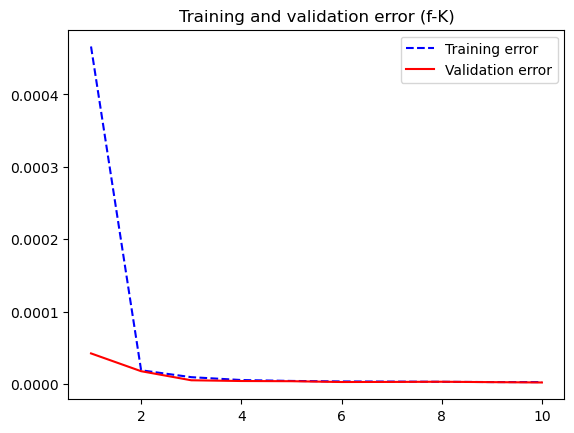

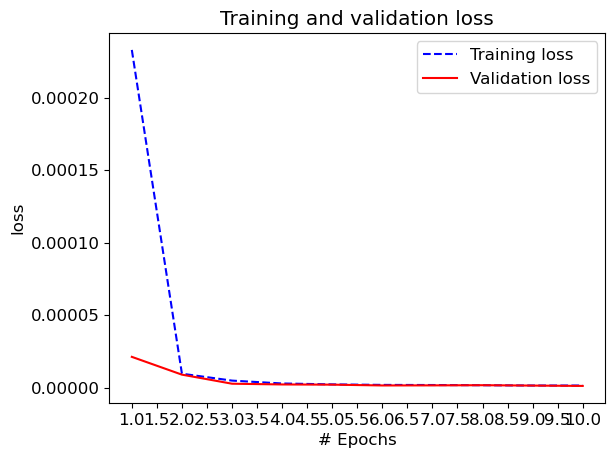

In [13]:

#  acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
acc = history.history['mean_squared_error']
val_acc = history.history['val_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '--b', label='Training error')
plt.plot(epochs, val_acc, 'r', label='Validation error')
plt.title('Training and validation error (f-K)')
plt.legend()
plt.show()

ax = plt.figure()
plt.rc('font', size=12)
plt.plot(epochs, loss, '--b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.locator_params(axis='x', nbins=20)
plt.xlabel('# Epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

In [14]:
#oad and compile the model as normal:
#model = load_model('2025_NOSI_short.h5',compile=False)

#If using custom loss functions:
model = load_model('2025_NOSI_short.h5', compile=False)
model.compile(loss="mean_squared_error", optimizer='adam', metrics=["mean_squared_error"])

preds_test = model.predict(FK_filt_te, verbose=1)

4/4 [==============================] - 2s 452ms/step


(640, 768)
The mean error of the ouput  IRFFT differences was: 181.77891789575716
The max error of the ouput  IRFFT differences  was: 1878807.7418491633


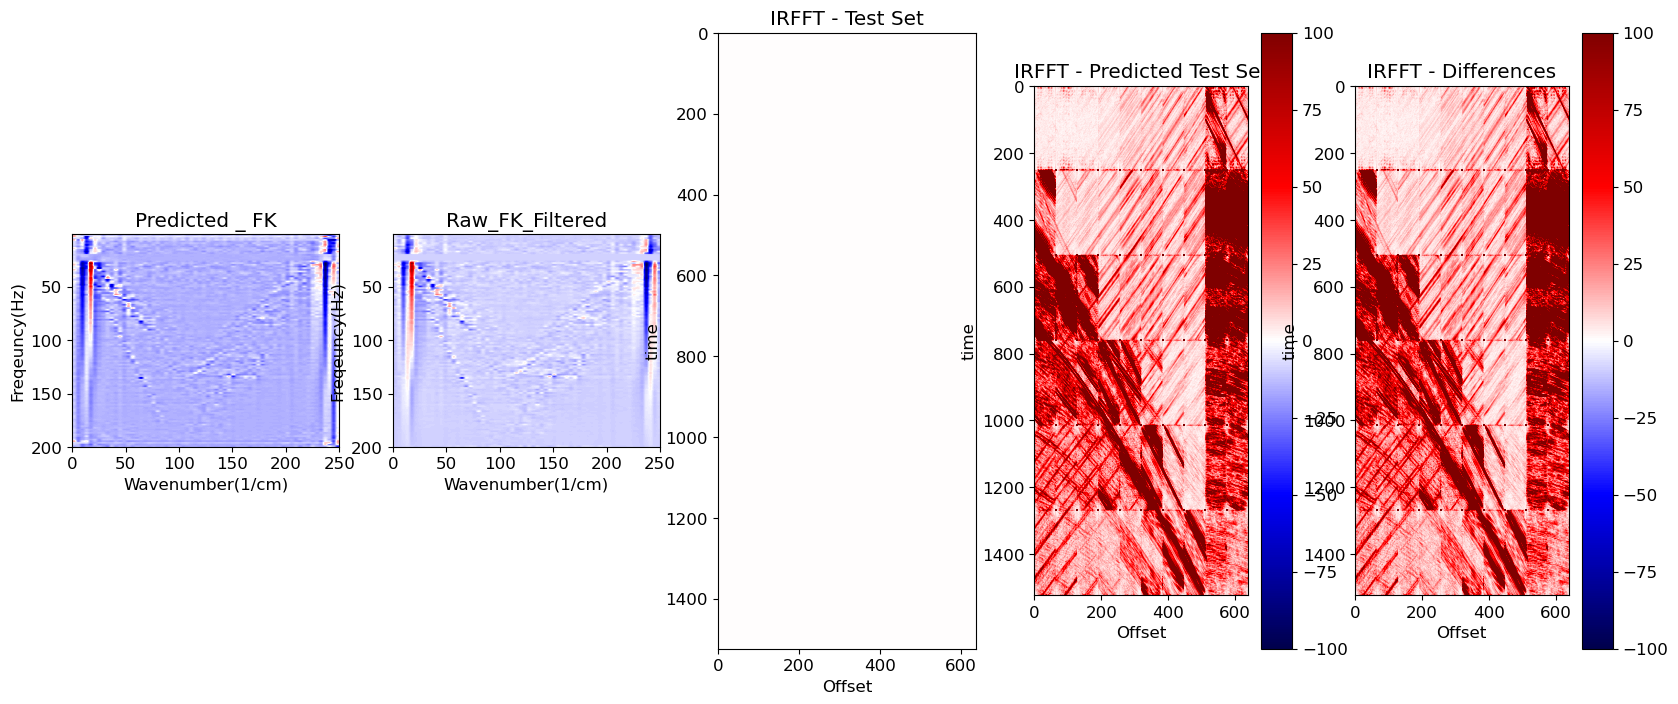

In [15]:
TGP=640
pred = np.zeros((640,128*6))
pred_irfft= np.zeros((640,254*6)) 

data = np.zeros((640,254*6))
rfft = np.zeros((TPG,128*6))
rfft_filtered= np.zeros((640,128*6))
rfft_filtered_1= np.zeros((640,128*6))
irfft = np.zeros((TPG,254*6))
irfft_filtered= np.zeros((640,254*6))
irfft_difference = np.zeros((640,254*6))
counter =0         
for i in range(0,10,1):
    for j in range (0,6,1):
        a = X_te[counter,:,:]
        b= Inv_FK_te[counter,:,:]
        c=  FK_te[counter,:,:]
        d=  FK_filt_te[counter,:,:] 
        
        e = Inv_FK_Filt_te[counter,:,:]  


        g = preds_test[counter].reshape((64,128))
        g = g*normfac

        f = np.abs(np.fft.irfft2(g)) 
        
        pred[i*64:64*i+64,j*128:128*j+128] = g
        pred_irfft[i*64:64*i+64,j*254:254*j+254] = f 
        
        data[i*64:64*i+64,j*254:254*j+254] = a.reshape((64,254))
        irfft[i*64:64*i+64,j*254:254*j+254] = b.reshape((64,254))
        rfft[i*64:64*i+64,j*128:128*j+128] = c.reshape((64,128))
        rfft_filtered[i*64:64*i+64,j*128:128*j+128] = d.reshape((64,128))
        #rfft_filtered_1[i*64:64*i+64,j*128:128*j+128] = d_1.reshape((64,128))
        irfft_filtered[i*64:64*i+64,j*254:254*j+254] = e.reshape((64,254))  
        irfft_difference[i*64:64*i+64,j*254:254*j+254] = (np.abs(e.reshape((64,254)) - f.reshape((64,254))))
        counter +=1
print(pred.shape)
plt.figure(figsize=(20,8))
plt.subplot(151)
plt.imshow(pred[0:64,0:128].T,cmap='seismic',extent=[0,250,200,1])
plt.xlabel('Wavenumber(1/cm)')
plt.ylabel('Freqeuncy(Hz)')
plt.title('Predicted _ FK')
plt.subplot(152)
plt.imshow((rfft_filtered[0:64,0:128].T),cmap='seismic',extent=[0,250,200,1])
plt.xlabel('Wavenumber(1/cm)')
plt.ylabel('Freqeuncy(Hz)')
plt.title('Raw_FK_Filtered')
plt.subplot(153)
plt.imshow((irfft.T),cmap='seismic',vmax=100,vmin=-100)
plt.xlabel('Offset')
plt.ylabel('time')
plt.title('IRFFT - Test Set')
plt.subplot(154)
plt.imshow((pred_irfft).T,cmap='seismic',vmax=100,vmin=-100)
plt.colorbar()
plt.xlabel('Offset')
plt.ylabel('time')
plt.title('IRFFT - Predicted Test Set')
plt.subplot(155)
plt.imshow((irfft_difference).T,cmap='seismic',vmax=100,vmin=-100)
plt.colorbar()
plt.xlabel('Offset')
plt.ylabel('time')
plt.title('IRFFT - Differences')
print('The mean error of the ouput  IRFFT differences was: ' + str(np.abs(np.mean(irfft_difference))))
print('The max error of the ouput  IRFFT differences  was: ' + str(np.abs(np.max(irfft_difference))))


In [16]:
print((preds_test[1].shape))
'''print(filtered_train.shape)
data = np.zeros((640,1524,1))
rfft = np.zeros((640,128*6,1))
rfft_filtered= np.zeros((640,128*6,1))
irfft = np.zeros((640,1524,1))
irfft_filtered= np.zeros((640,1524,1))
counter =0 
q=[]

for i in range(0,10,1):
    for j in range (0,6,1):
        a = FK_te[counter,:,:]
        b= FK_filt_te[counter,:,:]
        q=(Filt_te[counter,:,:])
        
        g = Inv_FK_Filt_te[counter,:,:]
        h = Inv_FK_te[counter,:,:]
        data[i*64:64*i+64,j*254:254*j+254] = q.reshape(64,254,1)
        rfft[i*64:64*i+64,j*128:128*j+128] = a.reshape(64,128,1)
        rfft_filtered[i*64:64*i+64,j*128:128*j+128] = b.reshape(64,128,1)
        irfft_filtered[i*64:64*i+64,j*254:254*j+254] = g.reshape(64,254,1)
        irfft_filtered[i*64:64*i+64,j*254:254*j+254] = h.reshape(64,254,1)  
        
        
        counter +=1
plt.figure(figsize=(20,8))
plt.subplot(141)
plt.imshow((data),cmap='seismic',vmax=100,vmin=-100)
plt.subplot(142)
plt.imshow(np.abs(rfft[64:128,128:256]),cmap='seismic',extent=[0,200,64,128])
plt.subplot(143)
plt.imshow (np.abs(rfft_filtered[64:128,128:256]),cmap='seismic')
plt.subplot(144)
plt.imshow (np.abs(irfft_filtered),cmap='seismic',vmax=100,vmin=-100)
plt.imshow (np.abs(preds_test[1]),cmap='seismic')'''

(64, 128, 1)


"print(filtered_train.shape)\ndata = np.zeros((640,1524,1))\nrfft = np.zeros((640,128*6,1))\nrfft_filtered= np.zeros((640,128*6,1))\nirfft = np.zeros((640,1524,1))\nirfft_filtered= np.zeros((640,1524,1))\ncounter =0 \nq=[]\n\nfor i in range(0,10,1):\n    for j in range (0,6,1):\n        a = FK_te[counter,:,:]\n        b= FK_filt_te[counter,:,:]\n        q=(Filt_te[counter,:,:])\n        \n        g = Inv_FK_Filt_te[counter,:,:]\n        h = Inv_FK_te[counter,:,:]\n        data[i*64:64*i+64,j*254:254*j+254] = q.reshape(64,254,1)\n        rfft[i*64:64*i+64,j*128:128*j+128] = a.reshape(64,128,1)\n        rfft_filtered[i*64:64*i+64,j*128:128*j+128] = b.reshape(64,128,1)\n        irfft_filtered[i*64:64*i+64,j*254:254*j+254] = g.reshape(64,254,1)\n        irfft_filtered[i*64:64*i+64,j*254:254*j+254] = h.reshape(64,254,1)  \n        \n        \n        counter +=1\nplt.figure(figsize=(20,8))\nplt.subplot(141)\nplt.imshow((data),cmap='seismic',vmax=100,vmin=-100)\nplt.subplot(142)\nplt.imshow(

 Plotting Prediction Test Data


23


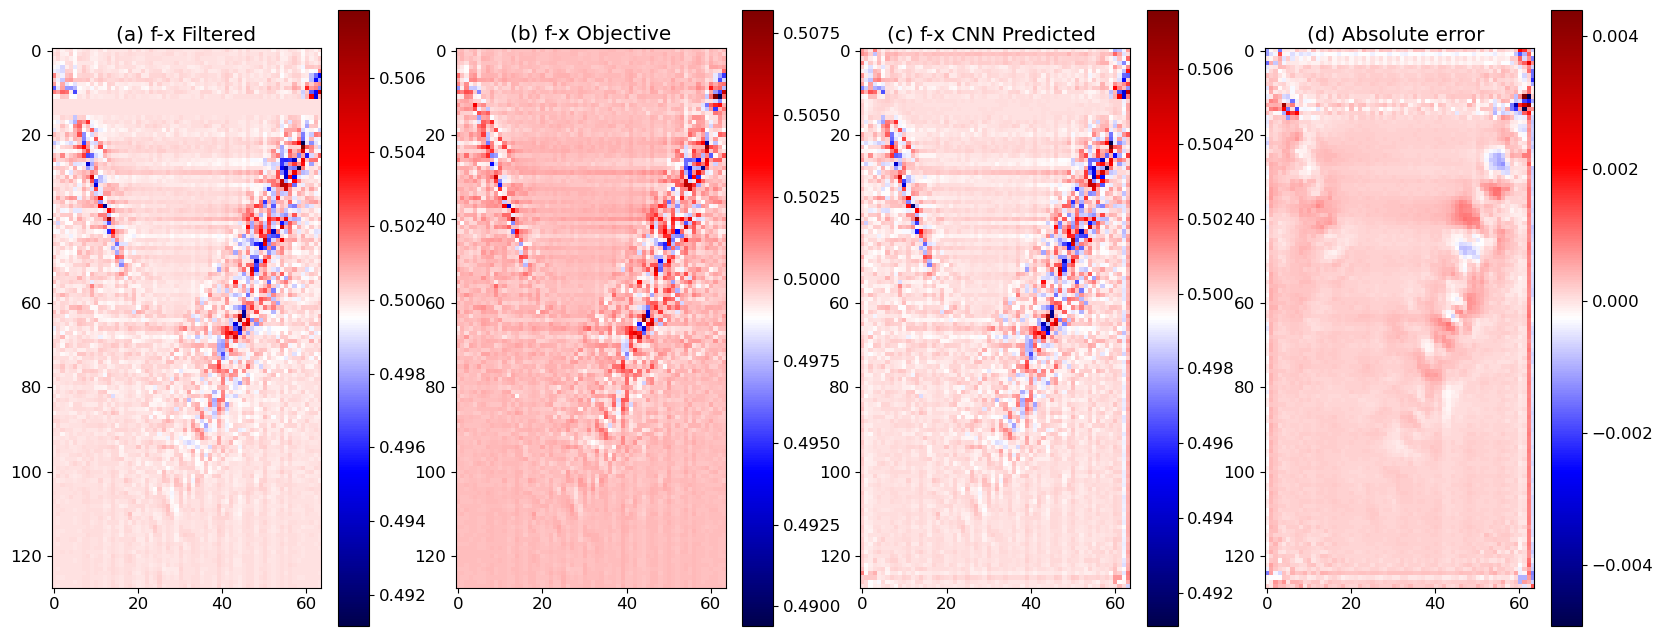

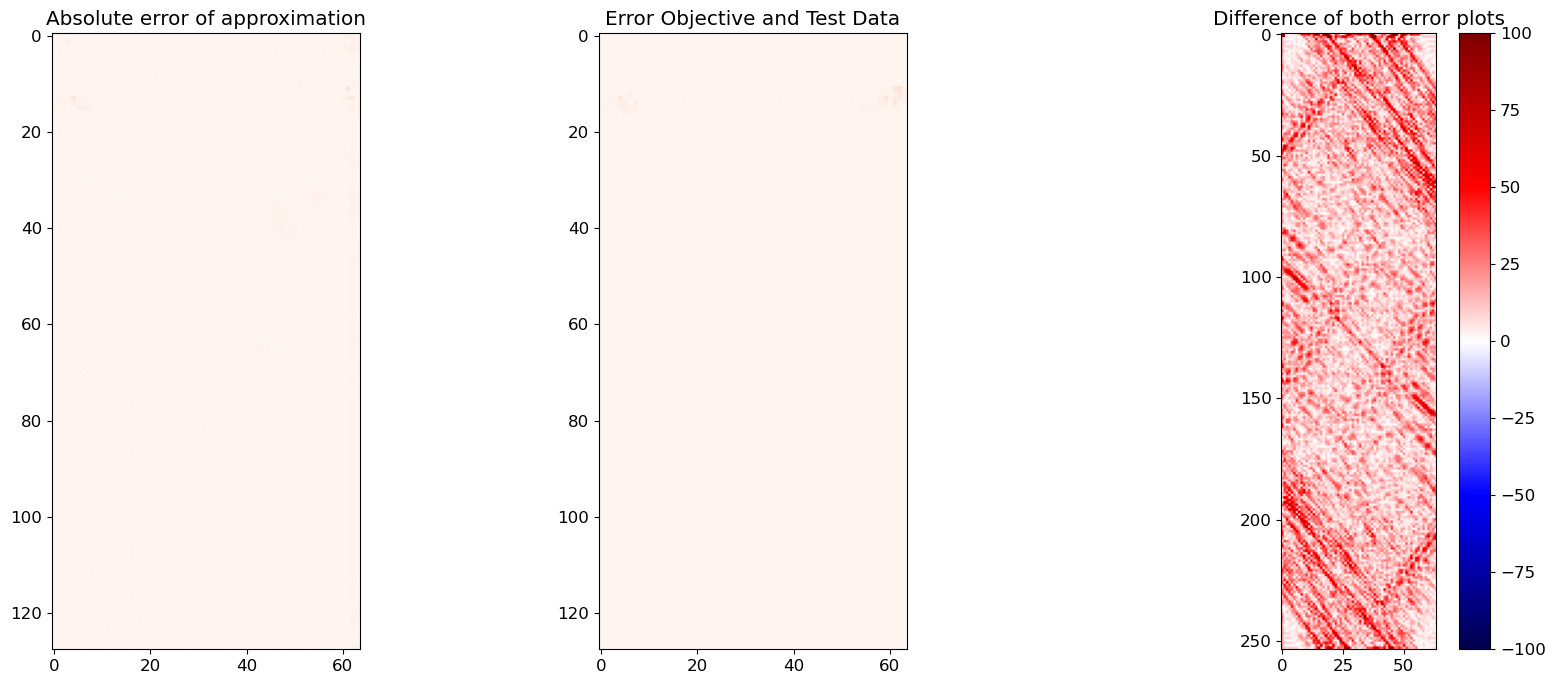

The MAE of the input data was(fk-fk_filt): 3.8045158387469406e-06
The MAE of the ouput data (fk-pred) was: 0.00014637698699657614
The MAE of the ouput data was (fk_filt - pred): 0.0001501815028353231
The max error of the input data was: 0.0040988312921752534
The max error of the ouput data was: 0.004400548688934358
The max error of the ouput  IRFFT data was: 131.75240707272823


In [19]:
# Perform a sanity check on some random validation samples

ix = random.randint(0, len(preds_test)-1)
#ix = 34
print(ix)
raw_filt = FK_filt_te[ix,:,:].reshape((64,128))
raw = FK_te[ix,:,:].reshape((64,128))
out = preds_test[ix,:,:].reshape((64,128))
raw_irfft = Inv_FK_te[ix,:,:].reshape((64,254))
out_irfft = np.abs(np.fft.irfft2(out))*normfac


f = plt.figure(figsize=(20,8))
ax1 = f.add_subplot(141)
plt.imshow(raw_filt.T, cmap='seismic')
plt.colorbar()
plt.title('(a) f-x Filtered')



ax2 = f.add_subplot(142)
plt.imshow((raw).T, cmap='seismic')
plt.title('(b) f-x Objective')
plt.colorbar()


ax3 = f.add_subplot(143)
plt.imshow((out).T, cmap='seismic')
plt.title('(c) f-x CNN Predicted ')
plt.colorbar()


ax4 = f.add_subplot(144)
plt.imshow((raw.T) - np.abs(out).T,cmap = 'seismic')
plt.title('(d) Absolute error ')
plt.colorbar()

plt.show()

f = plt.figure(figsize=(20,8))
ax = f.add_subplot(131)
plt.imshow(np.abs(raw).T - np.abs(out).T,cmap = 'Reds')
plt.clim(0, 0.05)
plt.title('Absolute error of approximation')

ax = f.add_subplot(132)
plt.imshow(np.abs(raw - raw_filt).T,cmap = 'Reds')
plt.clim(0, 0.05)
plt.title('Error Objective and Test Data')


ax = f.add_subplot(133)
plt.imshow(np.abs(raw_irfft-out_irfft).T,cmap = 'seismic',vmax=100,vmin=-100)
plt.colorbar()
plt.title('Difference of both error plots')

plt.show()

print('The MAE of the input data was(fk-fk_filt): ' + str(np.abs(np.mean(FK_te[ix,:,:]-FK_filt_te[ix,:,:]))))
print('The MAE of the ouput data (fk-pred) was: ' + str(np.abs(np.mean(FK_te[ix,:,:]-preds_test[ix,:,:]))))
print('The MAE of the ouput data was (fk_filt - pred): ' + str(np.abs(np.mean(FK_filt_te[ix,:,:]-preds_test[ix,:,:]))))
print('The max error of the input data was: ' + str(np.max(FK_te[ix,:,:]-FK_filt_te[ix,:,:])))
print('The max error of the ouput data was: ' + str(np.max(FK_te[ix,:,:]-preds_test[ix,:,:])))
print('The max error of the ouput  IRFFT data was: ' + str(np.abs(np.mean(raw_irfft - out_irfft))))


### Build Neural Network

In [6]:
## Defining Convlution Block, Bridge and Deconvolution block
'''num_filters=32
def conv_block(inputs,num_filters,batch_norm=False,dropout_prob=0):

    conv1 = Conv2D(num_filters, (3,3), padding="same", activation="relu",kernel_initializer='HeNormal')(inputs)
    conv2 = Conv2D(num_filters, (3,3), padding="same", activation="relu",kernel_initializer='HeNormal')(conv1)
    if batch_norm:
        conv1= BatchNormalization(axis=-1)(conv1)
    conv1 = ReLU(alpha=0.2)(conv1)

    conv2 = Conv2D(n_filters,3,padding='same')(conv1)
    if batch_norm:
        conv2= BatchNormalization(axis=-1)(conv2)
    conv2 = ReLU(alpha=0.2)(conv1)

    if dropout_prob > 0:
        conv2 = Dropout(dropout_prob)(conv2)

    return conv2

def encoder_block(inputs,num_filter,batch_norm=False,dropout_prob=0):

    skip_conncetion = conv_block(inputs,num_filters)
    next_layer = MaxPooling2D((2,2))(skip_conncetion)

    return next_layer,skip_conncetion

def decoder_block(inputs,skip_connection,num_filters,batch_norm = False, dropout_prob=0):

    up = Conv2DTranspose(num_filters, (3, 3), strides=(2,2), padding="same",kernel_initializer='HeNormal')(inputs)
    merge = Concatenate()([up, skip_connection])
    conv = conv_block(merge, num_filters)

    return conv

def unet_model(input_size = (512,64,1), n_filters=64,n_classes=5, batch_norm = True, dropout=np.zeros(9)):
    inputs = Input(input_size)
    ### Encoder
    enc_1 = encoder_block(inputs,n_filters,batch_norm,dropout_prob=dropout[0])
    enc_2 = encoder_block(enc_1[0],n_filters*2,batch_norm,dropout_prob=dropout[1])
    enc_3 = encoder_block(enc_2[0],n_filters*4,batch_norm,dropout_prob=dropout[2])
    enc_4 = encoder_block(enc_3[0],n_filters*8,batch_norm,dropout_prob=dropout[3])

    ## Bridge 
    bridge = conv_block(enc_4[0],n_filters*16,batch_norm,dropout_prob=dropout[4])

    ## Decoder
    dec_4 = decoder_block(bridge,enc_4[1],n_filters*8,batch_norm,dropout_prob=dropout[5])
    dec_3 = decoder_block(dec_4,enc_3[1],n_filters*4,batch_norm,dropout_prob=dropout[6])
    dec_2 = decoder_block(dec_3,enc_2[1],n_filters*2,batch_norm,dropout_prob=dropout[7])
    dec_1 = decoder_block(dec_2,enc_1[1],n_filters*1,batch_norm,dropout_prob=dropout[8])

    if n_classes == 2:
        conv10 = Conv2D(1,1,padding ='same')(dec_1)
        output = Activation('sigmoid')(conv10)

    else: 
        conv10 = Conv2D(n_classes,1,padding ='same')(dec_1)
        output = Activation('softmax')(conv10)

    model = tf.keras.Model(inputs = inputs, outputs = output, name='Unet')

    return model'''




'num_filters=32\ndef conv_block(inputs,num_filters,batch_norm=False,dropout_prob=0):\n\n    conv1 = Conv2D(num_filters, (3,3), padding="same", activation="relu",kernel_initializer=\'HeNormal\')(inputs)\n    conv2 = Conv2D(num_filters, (3,3), padding="same", activation="relu",kernel_initializer=\'HeNormal\')(conv1)\n    if batch_norm:\n        conv1= BatchNormalization(axis=-1)(conv1)\n    conv1 = ReLU(alpha=0.2)(conv1)\n\n    conv2 = Conv2D(n_filters,3,padding=\'same\')(conv1)\n    if batch_norm:\n        conv2= BatchNormalization(axis=-1)(conv2)\n    conv2 = ReLU(alpha=0.2)(conv1)\n\n    if dropout_prob > 0:\n        conv2 = Dropout(dropout_prob)(conv2)\n\n    return conv2\n\ndef encoder_block(inputs,num_filter,batch_norm=False,dropout_prob=0):\n\n    skip_conncetion = conv_block(inputs,num_filters)\n    next_layer = MaxPooling2D((2,2))(skip_conncetion)\n\n    return next_layer,skip_conncetion\n\ndef decoder_block(inputs,skip_connection,num_filters,batch_norm = False, dropout_prob=0):